Formation Data Analyst avec OpenClassrooms

Projet 10 : Détectez des faux billets avec R ou Python

Ainouni Anwar

In [1]:
!python --version

Python 3.9.12


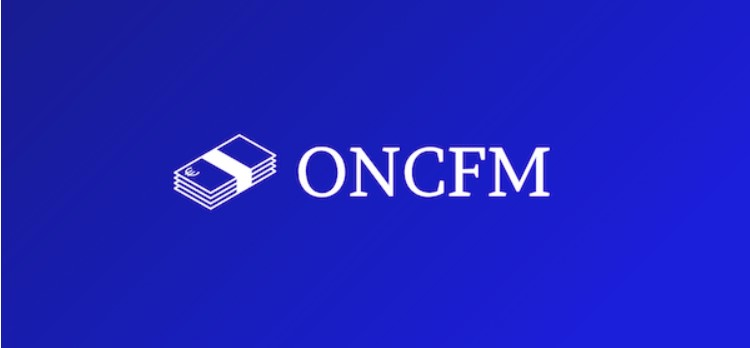

# Sommaire

- Exploration des données

- ACP

- Test statistique

- Imputation des données manquantes avec la regression lineaire multiple

- Programmation des algorithmes de classification
    * Régression logistique
    * kNN
    * K-means

- Fonction de détection les vrais des faux billets
 

# Préambule

Etant consultant Data Analyst dans une entreprise spécialisée dans la data. Mon entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).

Cette institution a pour objectif de **mettre en place des méthodes d’identification des contrefaçons des billets en euros.**

Ma mission est de mettre en place **une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets.** Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.

# Exploration des données

Importation des librairies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import decomposition

from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from matplotlib.collections import LineCollection

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *

import warnings
warnings.filterwarnings("ignore")

## Importation des données

In [3]:
billets = pd.read_csv('billets.csv', sep =';')

In [4]:
billets.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## Analyse descriptive

In [5]:
B_True = billets.loc[billets['is_genuine']== True]
B_False = billets.loc[billets['is_genuine']== False]
billets.info()
billets.describe()
B_True.info()
B_False.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1000 non-null   bool   
 1   diagonal      1000 non-null   float64
 2   height_left   1000 non-null   float64
 3   height_right  1000 non-null   float64
 4   margin_low    971 non-null    float64
 5   margin_up     1000 non-null   float64
 6   len

In [6]:
# Vérifier les doublons 
billets.duplicated().sum()

0

Observation :

On remarque la présence de **37 valeurs nulles** dans le variable "margin_low"

## Analyse Bivariée

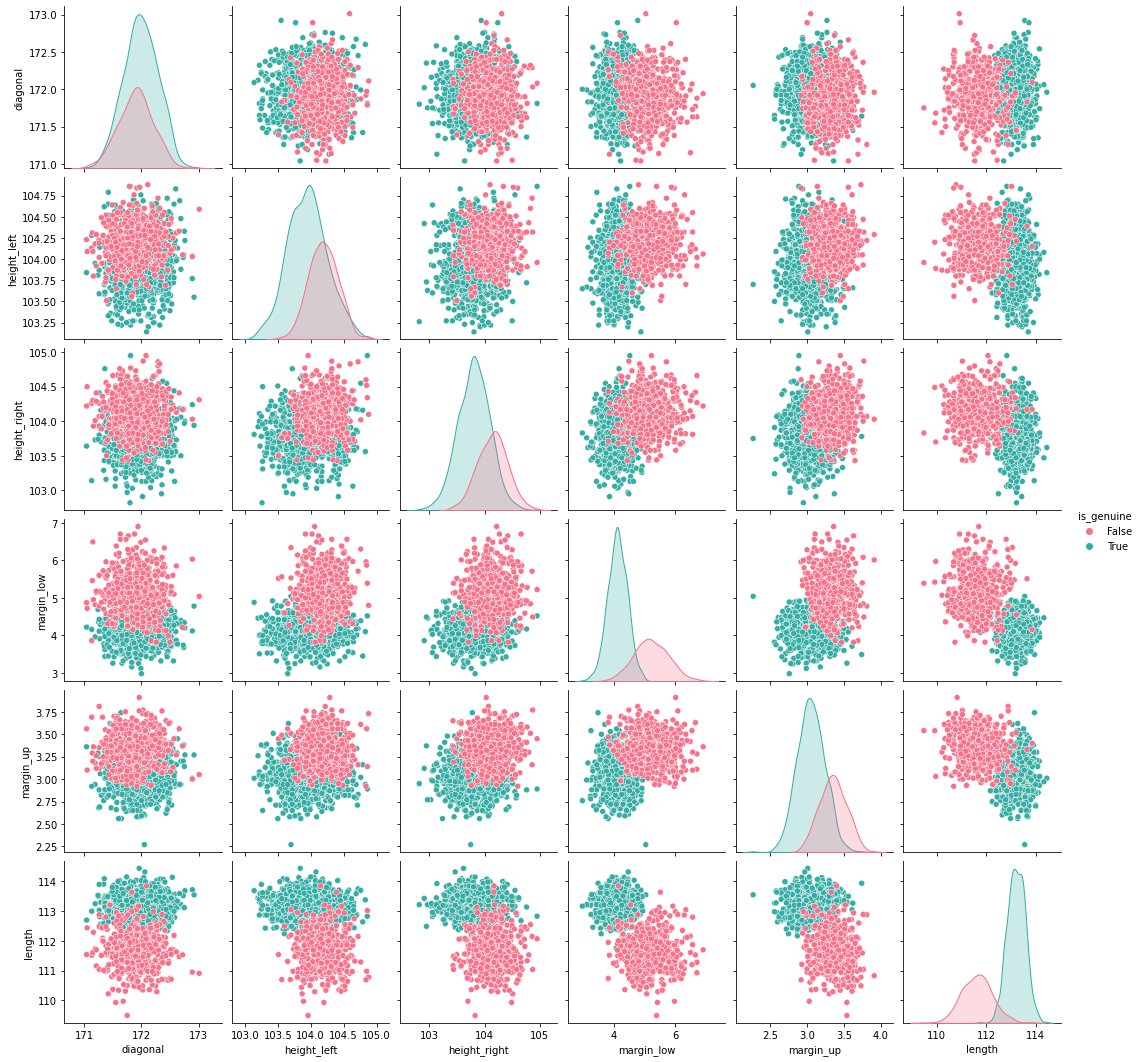

In [7]:
sns.pairplot(data=billets, hue='is_genuine',palette="husl")

Text(0.5, 1.0, 'length')

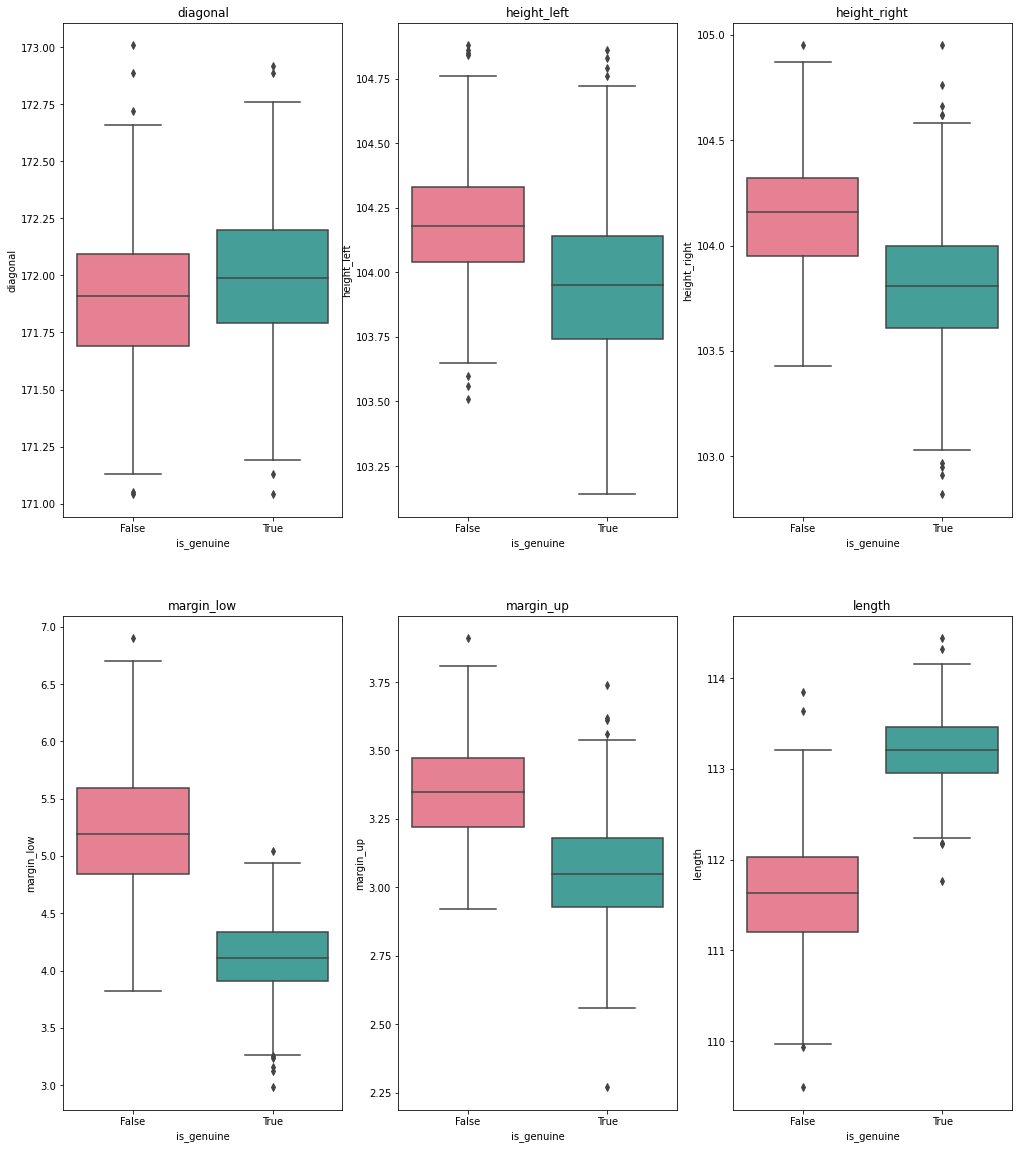

In [8]:
# Distribution des données en boîte à moustaches
f, axes = plt.subplots(2,3,figsize = (17,20))
sns.boxplot(y='diagonal', x='is_genuine', data=billets,ax=axes[0, 0],palette="husl")
axes[0, 0].set_title('diagonal')
sns.boxplot(y='height_left', x='is_genuine', data=billets,ax=axes[0, 1],palette="husl")
axes[0, 1].set_title('height_left')
sns.boxplot(y='height_right', x='is_genuine', data=billets,ax=axes[0, 2],palette="husl")
axes[0, 2].set_title('height_right')
sns.boxplot(y='margin_low', x='is_genuine', data=billets,ax=axes[1, 0],palette="husl")
axes[1, 0].set_title('margin_low')
sns.boxplot(y='margin_up', x='is_genuine', data=billets,ax=axes[1, 1],palette="husl")
axes[1, 1].set_title('margin_up')
sns.boxplot(y='length', x='is_genuine', data=billets,ax=axes[1, 2],palette="husl")
axes[1, 2].set_title('length')

Observation :

Les variables "length" et "margin low" séparent le mieux les vrais des faux billets

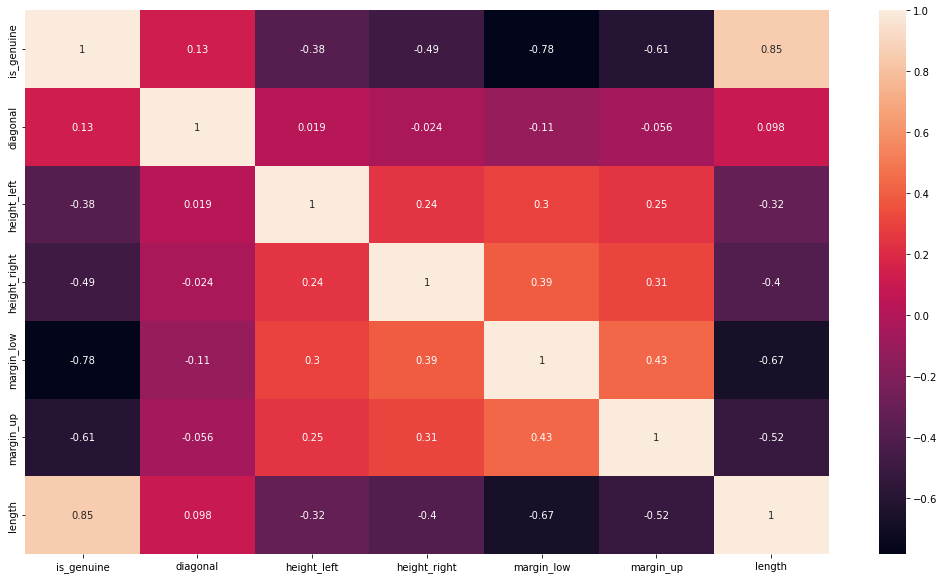

In [9]:
# Vérification de corrélation entre les variables
plt.figure(figsize=(18,10))
sns.heatmap(billets.corr(), annot=True)
plt.show()

Observation :

La heatmap permet de mettre en relief les corrélations observables dans le dataframe. Dans cette heatmap, on peut mettre en évidence un lien positif fort entre la variable 'length' et 'is_genuine’, 'margin_low’ et ‘margin_up', un lien négatif fort entre 'margin_low' et 'is_genuine’, 'margin_low’ et ‘length’. 

# Analyse en composantes principales (ACP)

## Préparation des données

In [10]:
data_Null = billets.dropna(how='any')
DF = data_Null.drop(columns= ['is_genuine'])
# dans array numpy
X = DF.values 
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_cr = std_scale.transform(X)

### Eboulis des valeurs propres

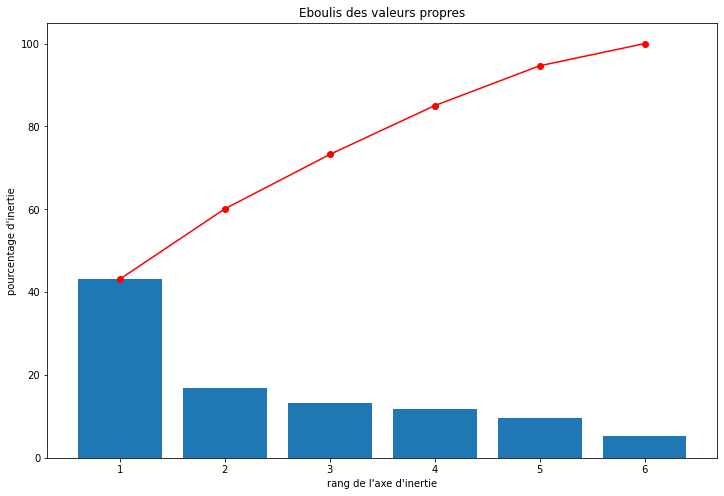

In [11]:
pca = decomposition.PCA().fit(X_cr) #sklearn
varexpl = pca.explained_variance_ratio_*100
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [12]:
print(varexpl)

[43.12352713 16.97065144 13.13642303 11.79216859  9.62035986  5.35686995]


In [13]:
scree_cum = varexpl.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

### Composantes principales

In [14]:
#la matrice de corrélation

t=pca.components_[:]
df_corr_comp = pd.DataFrame(t,index = ['F1', 'F2', 'F3','F4','F5','F6'],columns=DF.columns)
df_corr_comp.head(6).round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.09,0.33,0.39,0.51,0.44,-0.53
F2,0.94,0.31,0.12,-0.07,-0.01,0.05
F3,-0.28,0.89,-0.22,-0.10,-0.23,0.14
F4,-0.13,0.00,0.85,-0.09,-0.47,0.18
F5,-0.12,0.09,0.25,-0.57,0.71,0.30
F6,0.01,0.00,0.01,0.62,0.18,0.76


In [15]:
def cerle_corr(t, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            #fig, ax = plt.subplots(figsize=(12,(n_comp*2)))
            #ax.set_aspect('equal', adjustable='box')
            fig=plt.figure(figsize=(12,12))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box')

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
        
            # affichage des flèches
            plt.quiver(np.zeros(t.shape[1]), np.zeros(t.shape[1]),
                   t[d1,:], t[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(t[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

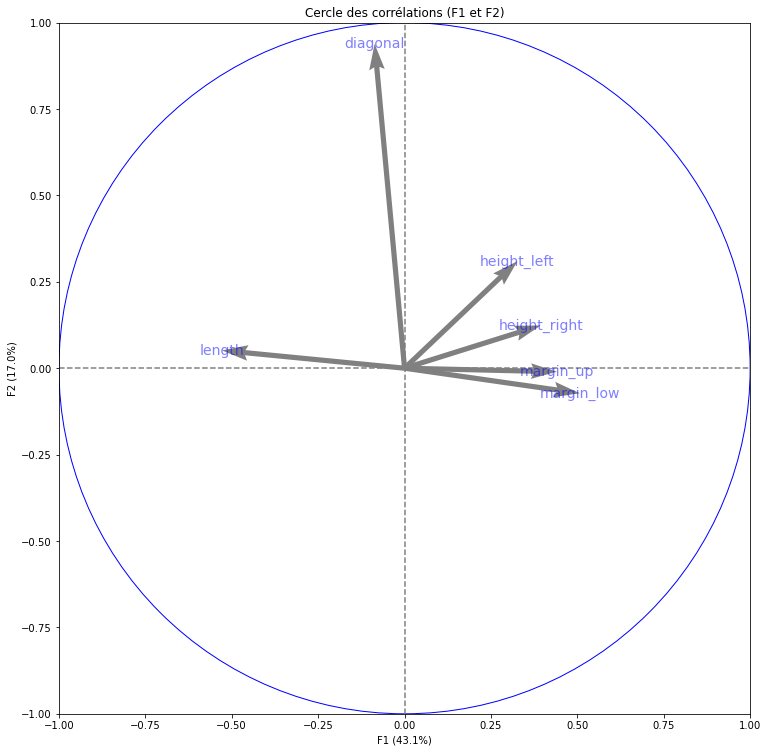

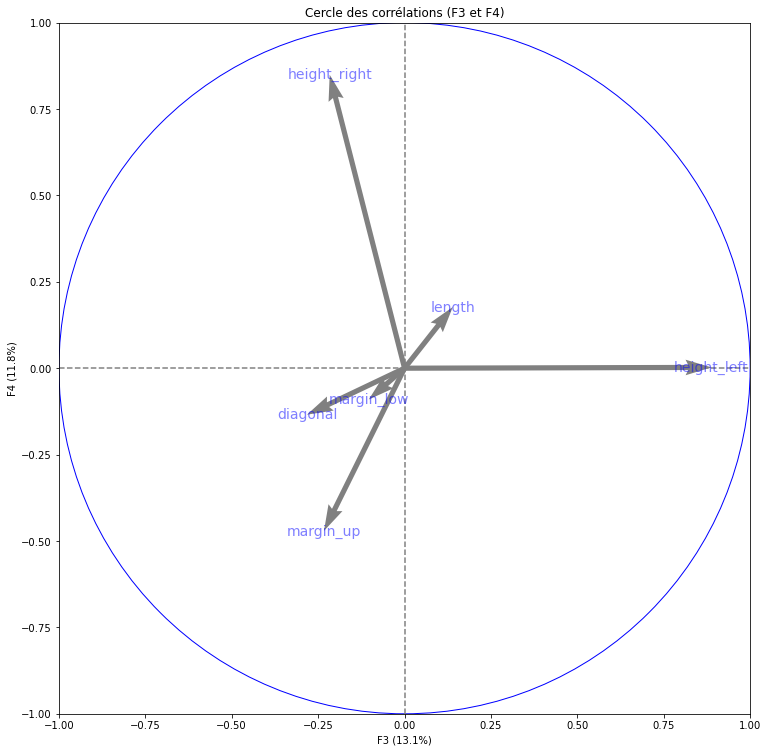

In [16]:
cerle_corr(t, 4, pca, [(0,1),(2,3)], labels = np.array(DF.columns))

Observation:

- Les variables les plus corrélées positivement à F1 sont 'height' et 'margin'
- Les variables les plus corrélées  négativement à F1 est 'length'
- Les variables les plus corrélées positivement à F2 est 'diagonal'

### Projection du variable "is_genuine"

In [17]:
# Affichage sur plusieurs plans factoriels avec inertie des axes.
def plot_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, centroid=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
         
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), fontsize=22)
            plt.show(block=False)

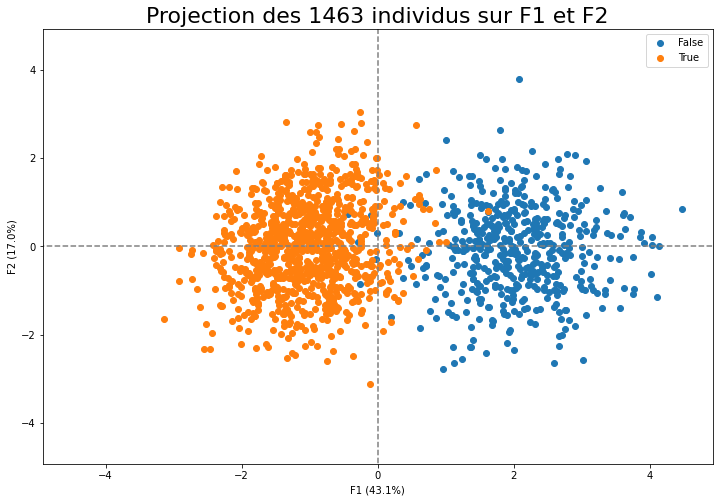

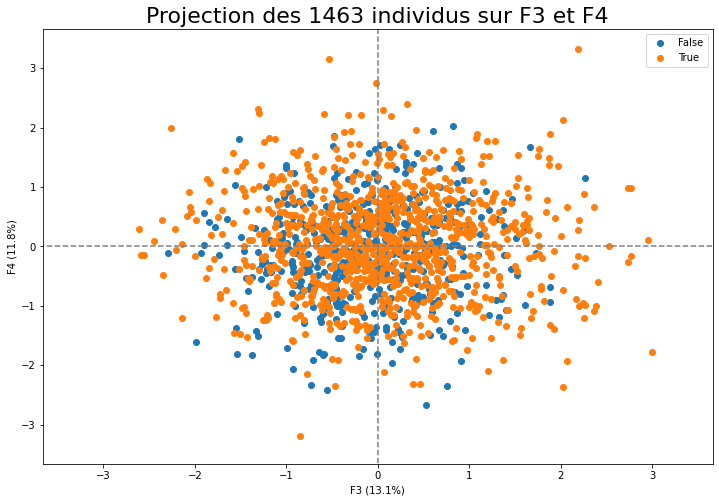

In [18]:
X_projected = pca.transform(X_cr)
plot_plans_factoriels(X_projected, 4, pca, [(0,1),(2,3)], illustrative_var = data_Null["is_genuine"])

# Test statistique

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from scipy import stats

In [20]:
# Dataframe ne comprenant pas les valeurs manquantes:
donnees_sans_nan = billets.dropna(how='any')
donnees_sans_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


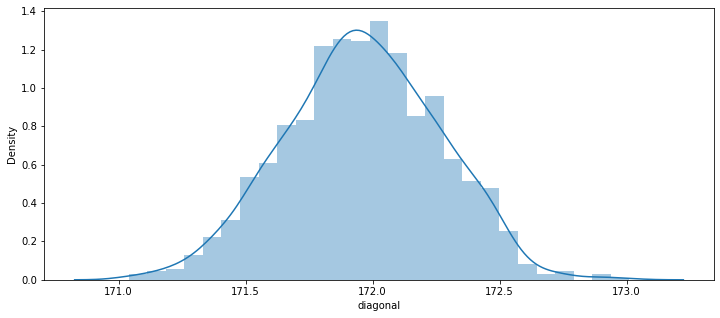

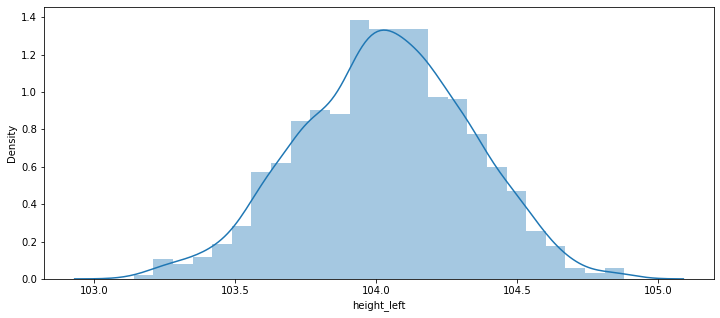

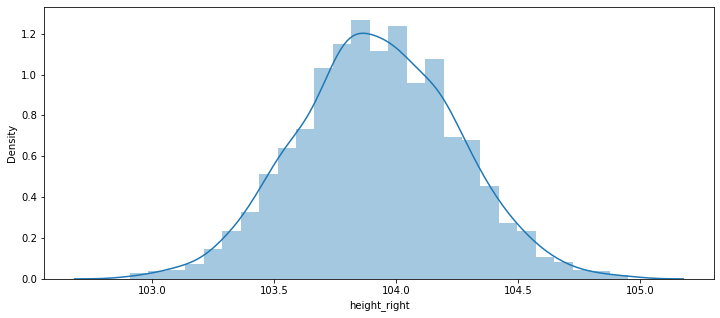

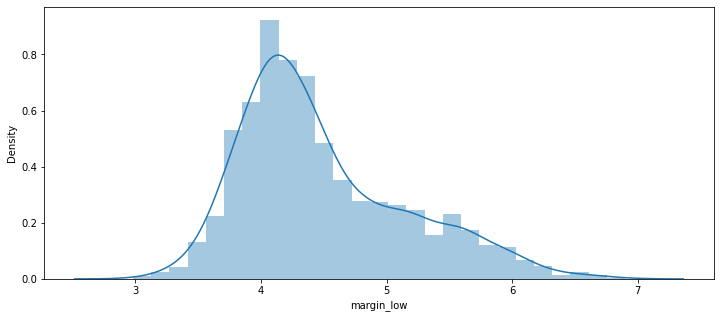

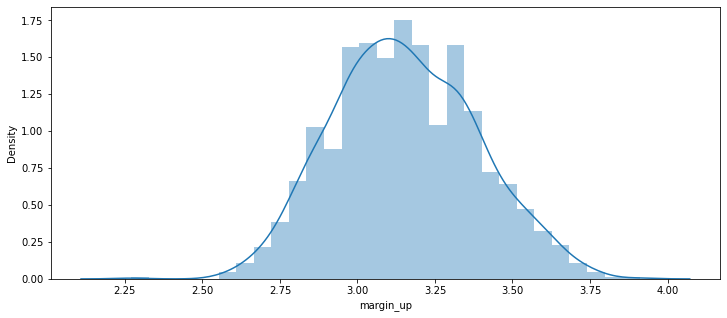

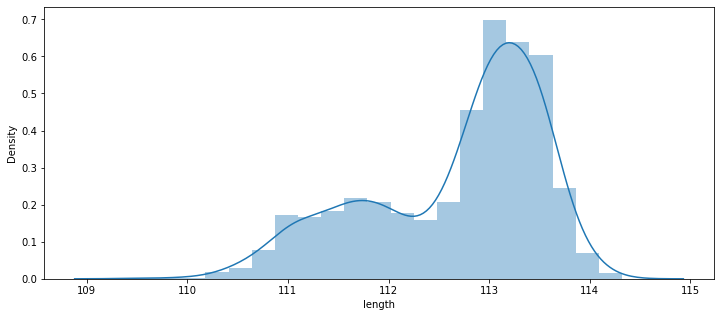

In [21]:
def distribution (donnees_sans_nan): 

    variable = donnees_sans_nan.columns[1:]

    for i in variable : 
        plt.figure(figsize=(12,5))
        sns.distplot(donnees_sans_nan[i])
        plt.show()
distribution (donnees_sans_nan)

## Test de la normalité des distributions (Shapiro-Wilk )

Avec un risque premier alpha de 5%, on émet les deux hypothèses suivantes:  
H0:la variable suit une loi normale  
H1:la variable ne suit pas une loi normale

In [22]:
DSN=donnees_sans_nan.drop(columns= ['is_genuine'])
DSN.columns.values.tolist()

['diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length']

In [23]:
#ShapiroTest:
alpha = 0.05

for i in DSN.iloc[:,:]:
    stat, pvalue = stats.shapiro(donnees_sans_nan[i])
    print(pvalue)
    if pvalue > alpha:
        print("Les données suivent une loi normale")
    else:
        print("Nous rejetons l’hypothèse nulle, les données ne suivent pas une loi normale")

0.26814448833465576
Les données suivent une loi normale
0.05767116695642471
Les données suivent une loi normale
0.9570105075836182
Les données suivent une loi normale
2.828552677965396e-24
Nous rejetons l’hypothèse nulle, les données ne suivent pas une loi normale
0.00047691623331047595
Nous rejetons l’hypothèse nulle, les données ne suivent pas une loi normale
1.076909632161875e-27
Nous rejetons l’hypothèse nulle, les données ne suivent pas une loi normale


On trouve que les données des 'diagonal','height_left','height_right' ***suivent une loi normale**,  
les données des 'margin_low','margin_up', 'length'***ne suivent pas une loi normale***.

## Test des differences entre les billets 'True' et 'False' 

on va utiliser Anova pour les variable qui suivent une loi normale et  Kruskal – Wallis pour les variables ne suivent pas une loi normale

###  Analyse de la variance (ANOVA)

Avec un risque premier alpha de 5%, on émets les deux hypothèses suivantes:  
H0: Les moyennes de 'margin_low' des vrais billets et faux billets sont sont égaux  
H1: Les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

In [24]:
from scipy import stats
group1=donnees_sans_nan[donnees_sans_nan.is_genuine == True].diagonal 
group2=donnees_sans_nan[donnees_sans_nan.is_genuine == False].diagonal

#perform anova Test 
stats.f_oneway(group1, group2)


F_onewayResult(statistic=27.00642755639178, pvalue=2.3146624660881635e-07)

- p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

In [25]:
from scipy import stats
group1=donnees_sans_nan[donnees_sans_nan.is_genuine == True].height_left 
group2=donnees_sans_nan[donnees_sans_nan.is_genuine == False].height_left

#perform anova Test 
stats.f_oneway(group1, group2)

F_onewayResult(statistic=237.03704807380916, pvalue=1.1114157003721756e-49)

- p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

In [26]:
from scipy import stats
group1=donnees_sans_nan[donnees_sans_nan.is_genuine == True].height_right 
group2=donnees_sans_nan[donnees_sans_nan.is_genuine == False].height_right

#perform anova Test 
stats.f_oneway(group1, group2)

F_onewayResult(statistic=454.6683446453273, pvalue=4.708598379063427e-88)

- p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

### Test de Kruskal-Wallis

Avec un risque premier alpha de 5%, on émets les deux hypothèses suivantes:  
H0: Les moyennes de 'margin_low' des vrais billets et faux billets sont sont égaux  
H1: Les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

In [27]:
from scipy import stats
group1=donnees_sans_nan[donnees_sans_nan.is_genuine == True].length 
group2=donnees_sans_nan[donnees_sans_nan.is_genuine == False].length

#perform Kruskal-Wallis Test 
stats.kruskal(group1, group2)

KruskalResult(statistic=916.9098418068461, pvalue=2.069483789921139e-201)

- p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

In [28]:
from scipy import stats
group1=donnees_sans_nan[donnees_sans_nan.is_genuine == True].margin_up 
group2=donnees_sans_nan[donnees_sans_nan.is_genuine == False].margin_up

#perform Kruskal-Wallis Test 
stats.kruskal(group1, group2)

KruskalResult(statistic=549.8948923584292, pvalue=1.326952298579742e-121)

- p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

In [29]:
from scipy import stats
group1=donnees_sans_nan[donnees_sans_nan.is_genuine == True].margin_low 
group2=donnees_sans_nan[donnees_sans_nan.is_genuine == False].margin_low

#perform Kruskal-Wallis Test 
stats.kruskal(group1, group2)

KruskalResult(statistic=828.742802832455, pvalue=3.040847316225815e-182)

- p_value < 0.05, nous rejetons l’hypothèse nulle, donc les moyennes de 'margin_low' des vrais billets et faux billets ne sont pas égaux

Observation :

Tous les variables presentent des valeurs differentes et significatives entre les billets 'True' et les billets 'False'

# Imputation des données manquantes avec la regression lineaire multiple

In [30]:
# Dataframe ne comprenant pas les valeurs manquantes:
data_Null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


Appliquons la régression linéaire multiple à l'échantillon 'billets'. Modélisons 'margin_low' en fonction de toutes les autres variables.

In [31]:
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=data_Null).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          4.75e-299
Time:                        11:42:24   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

Nous obtenons des statistiques sur l'écart-type, la statistique de test de Student, et la p-valeur (le test effectué sur le paramètre est ici le test de significativité.

Un modèle correct doit avoir des paramètres significatifs.

Un test de **significativité** sur chacune des variables explicatives prises une à une. Dans ce cas, il s'agit d'un test de Student, tout comme en régression linéaire simple. Ici, tester l'un des paramètres a un réel sens : si une variable n'est pas significative, il faut la retirer du modèle. Si l'on ne la retire pas, il est possible que l'erreur de prévision du modèle soit plus élevée.

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur **p-valeur n'est pas inférieure à 5 %**, le niveau de test que nous souhaitons.

P>|t| : La sortie de régression ci-dessus montre que les variables prédictives **is_genuine** et **margin_up** sont statistiquement significatives car leurs valeurs p sont égales à **0,000**. D'un autre côté, **les autres variables ne sont pas statistiquement significatives car leurs valeurs p sont supérieures** au niveau de signification habituel de **0,05**. 

On considère souvent le coefficient de détermination ajusté défini de la manière suivante (dans le cas de la régression avec constante) :

R2 ajusté = 1−nn−p(1−R2)

Si R2=1 , on a alors SCE=SCT : toute la variation est expliquée par le modèle.

Si R2=0 , on a alors SCR=SCT : aucune variation n'est expliquée par le modèle.

Le  𝑅2  vaut environ 0.617, et le  𝑅2  ajusté est d'environ **0.615**.


* Retrait des variables non significatives

On va donc maintenant retirer les variables non significatives avec la procédure descendante ou backward, on commence par la moins significative : length, car elle a une p-valeur de 0.868.

In [32]:
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up', data=data_Null).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          2.12e-300
Time:                        11:42:24   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.4247      7

On voit alors que c'est maintenant diagonal, avec une p-valeur de 0.719, qui est la moins significative. On l'enlève donc.

In [33]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up', data=data_Null).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          8.76e-302
Time:                        11:42:24   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3902      5

On voit alors que c'est maintenant height_right, avec une p-valeur de 0.496, qui est la moins significative. On l'enlève donc.

In [34]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+margin_up', data=data_Null).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          3.63e-303
Time:                        11:42:24   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9104      4

On voit alors que c'est maintenant height_left, avec une p-valeur de 0.454, qui est la moins significative. On l'enlève donc.

In [35]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=data_Null).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          1.24e-304
Time:                        11:42:24   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

Le 𝑅2 vaut environ 0.617, et le 𝑅2 ajusté est d'environ 0.616.

On peut donc utiliser ce modèle (avec les variables 'is_genuine' et 'margin_up') à des fins de prévision de la variable 'margin_low'

 ## Hypothèses de validité 

### Test de la normalité des résidus

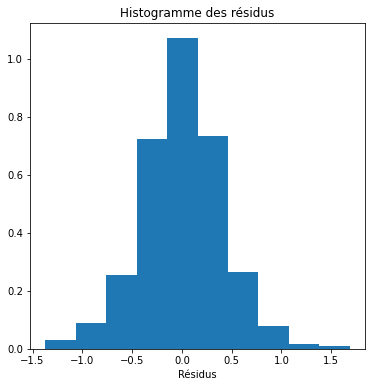

In [36]:
df_res=data_Null.copy()
df_res['residu_s'] = reg_multi.resid
plt.figure(figsize=(6,6))
plt.hist(df_res['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

L’allure de l’histogramme est assez classique : centrée et à peu près symétrique.

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [37]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value = 6.20e-06 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

### Vérification de la colinéarité des variables

Dans une régression, la multicolinéarité est un problème qui survient lorsque certaines variables de prévision du modèle mesurent le même phénomène. Une multicolinéarité prononcée s’avère problématique, car elle peut augmenter la variance des coefficients de régression et les rendre instables et difficiles à interpréter. Les conséquences de coefficients instables peuvent être les suivantes :

les coefficients peuvent sembler non significatifs, même lorsqu’une relation significative existe entre le prédicteur et la réponse ;

les coefficients de prédicteurs fortement corrélés varieront considérablement d’un échantillon à un autre ;

lorsque des termes d’un modèle sont fortement corrélés, la suppression de l’un de ces termes aura une incidence considérable sur les coefficients estimés des autres. Les coefficients des termes fortement corrélés peuvent même présenter le mauvais signe.

In [38]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

### Test de l’homoscédasticité  

On peut également tester l’homoscédasticité (**c'est-à-dire la constance de la variance**) des résidus :

In [39]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.2033559115838186e-36


La p-valeur ici est inférieure à  5 %, on rejette l'hypothèse  𝐻0  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

Observation:

Dans le cas d’un “grand échantillon”,
les propriétés asymptotiques des estimateurs corrigent un manque “raisonnable” de normalité des résidus : le modèle linéaire est dit robuste vis à vis de cette hypothèse.

Pour plus de détails sur ce sujet on peut se referrer vers ses deux liens : [Ici](https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-l-inf-intRegmult.pdf)  et [Là](http://perso.ens-lyon.fr/lise.vaudor/non-respect-des-hypotheses-du-modele-lineaire-anova-regression-cest-grave-docteur/) 


## Analyse des resultats

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [40]:
alpha = 0.05
n = data_Null['margin_low'].count() 
p = 6

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.

In [41]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

### Calcule des leviers (Analysez l'atypicité des observations)

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [42]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

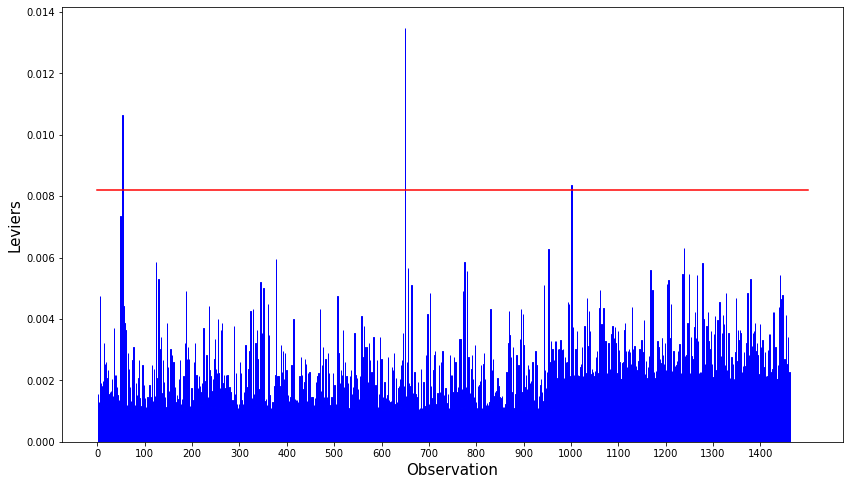

In [43]:
plt.figure(figsize=(14,8))
plt.bar(analyses['obs'], analyses['levier'], edgecolor='blue')
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation', fontsize=15)
plt.ylabel('Leviers', fontsize=15)
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [44]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
52,53,0.010647
649,650,0.013491
1000,1001,0.008380


En pratique, on ne retire que les observations atypiques ET influentes.

### Calcule des résidus studentisés

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [45]:
from scipy.stats import t
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

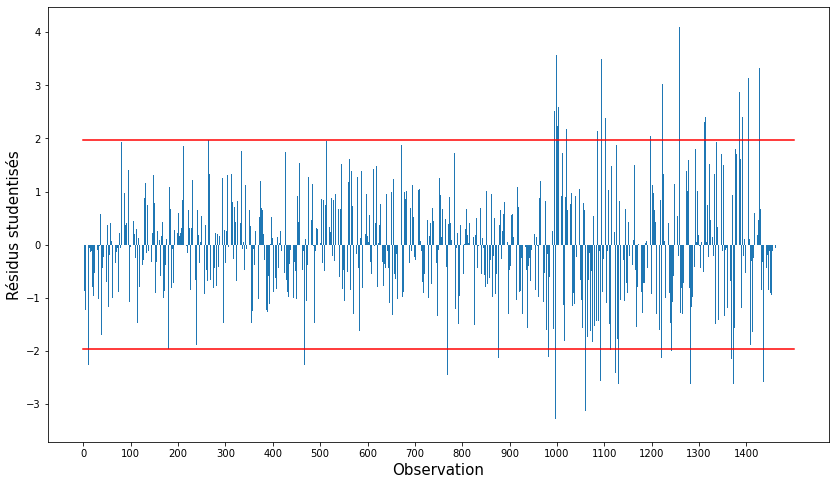

In [46]:
plt.figure(figsize=(14,8))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation', fontsize=15)
plt.ylabel('Résidus studentisés', fontsize=15)
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

### Distance de Cook(Analysez l'influence des observations)

Cook a proposé de considérer l'observation i comme influente si : 

Di>4n−p

In [47]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p.

In [48]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

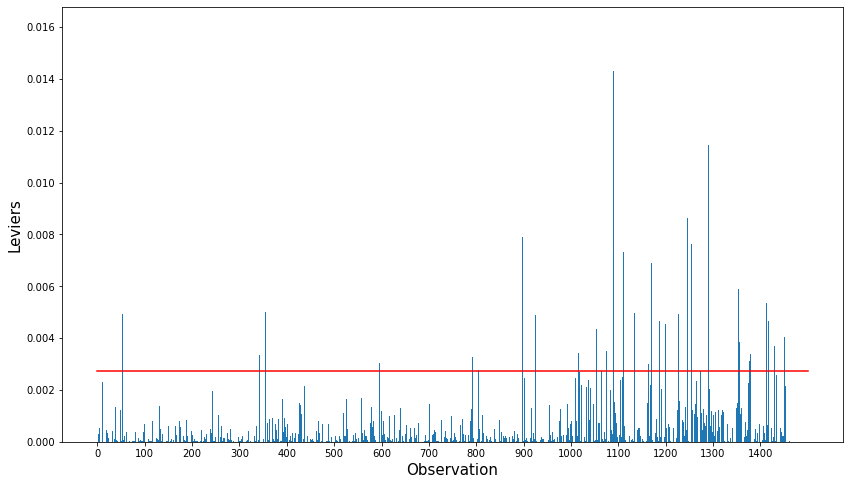

In [49]:
plt.figure(figsize=(14,8))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation', fontsize=15)
plt.ylabel('Leviers', fontsize=15)
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [50]:
analyses.loc[analyses['dcooks'] > seuil_dcook, :]

,obs,levier,rstudent,dcooks
52,53,0.010647,-1.174185,0.004945
125,126,0.001204,0.667241,0.006626
239,240,0.001671,-0.215304,0.005198
341,342,0.001708,1.131974,0.003332
354,355,0.001204,-1.473461,0.004993
...,...,...,...,...
1426,1427,0.004228,-1.940064,0.005707
1429,1430,0.002053,0.675065,0.003686
1441,1442,0.005428,2.317452,0.010969
1450,1451,0.002703,-0.911463,0.004051


## Amélioration du modèle

In [51]:
atypiques = analyses.loc[analyses['levier'] > seuil_levier, :]
influents =analyses.loc[analyses['dcooks'] > seuil_dcook, :]

In [52]:
atypiques_influents = influents.merge(atypiques, how = 'inner' )
atypiques_influents
#(décalage +1 obs)

,obs,levier,rstudent,dcooks
0,53,0.010647,-1.174185,0.004945


C'est la ligne 52 (décalage +1 obs) à la fois atypique et influente, on peut l'ignorer...

## Imputation

In [53]:
nan = billets[billets.isnull().any(axis=1)]
prediction_RegL = round(reg_multi.predict(nan),2)
df = billets.copy()

In [54]:
df['margin_low'] = df['margin_low'].fillna(prediction_RegL)
df.iloc[[72,99,151,197],:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.07,3.25,112.79
99,True,171.93,104.07,104.18,4.10,3.14,113.08
151,True,172.07,103.80,104.38,4.12,3.02,112.93
197,True,171.45,103.66,103.80,4.00,3.62,113.27


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# Programmation des algorithmes de classification

## Echantillonner les données

Pour exploiter correctement les données :

S’il y en a beaucoup, on travaille d'abord uniquement avec un échantillon représentatif pour pouvoir aller plus vite.

**On sépare dès le départ en deux parties notre jeu de données** : **un training set** pour créer le modèle et un **testing set** pour tester la qualité du modèle.

Le training set, qui va nous permettre d’entraîner notre modèle et sera utilisé par l’algorithme d’apprentissage. C'est celui dont on a parlé depuis le début.

Le testing set, qui permet de mesurer l’erreur du modèle final sur des données qu’il n’a jamais vues. On va simplement passer ces données comme s'il s'agissait de données que l’on n'a encore jamais rencontrées (comme cela va se passer ensuite en pratique pour prédire de nouvelles données) et mesurer la performance de notre modèle sur ces données. On appelle aussi cela held-out data, pour souligner que ce sont des données auxquelles on ne va pas toucher avant la toute fin pour pouvoir être bien sûr que le modèle fonctionne.

En général, les données sont séparées avec les proportions suivantes : **80 %** pour le training set et **20 %** pour le testing set.

On peut  utiliser tout le dataset pour entraîner le modèle final. Mais pour explorer et pour le travail quotidien, il vaut en général mieux tester sur une petite partie des données.

* Préparation des données

In [56]:
X = df.drop(['is_genuine'], axis=1)
y = df['is_genuine']

In [57]:
# Séparer training / testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

## Algorithme k-means

K-Means est un algorithme simple d’apprentissage non supervisé utilisé pour résoudre les problèmes de clustering. Il suit une procédure simple, consistant à classer un ensemble de données dans un nombre de clusters, défini par la lettre « k« , qui est fixé au préalable.

**L’algorithme associe chaque donnée à son centroïde le plus proche, afin de créer des cluster.**

On positionne ensuite les clusters comme des points. On associe tous les observations ou points de données au cluster le plus proche, calculés et ajustés. Puis, le processus recommence en utilisant les nouveaux ajustements jusqu’à ce qu’un résultat souhaité soit atteint.

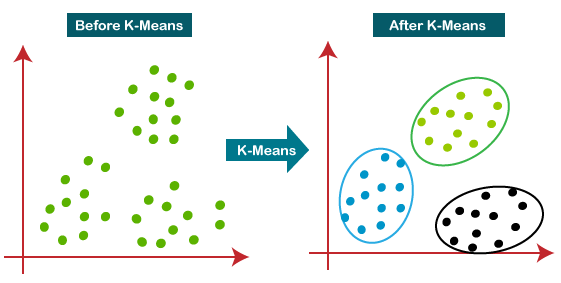

### Méthode du coude

Pour déterminer le nombre de clusters à étudier, on s'intéresse au graphique qui trace l'inertie intraclasse en fonction du nombre de clusters. On cherche plus particulièrement une "cassure" dans la courbe. 

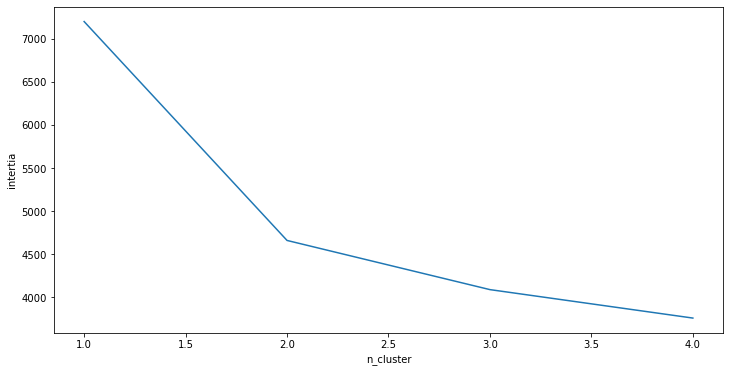

In [58]:
X = X_train.values 
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_cr = std_scale.transform(X)
intertia = []
k_list = range(1, 5)
list(k_list)
for i in k_list :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_cr) 
    intertia.append(kmeans.inertia_)
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia)

Observation :

La méthode du coude nous donne le nombre de cluster optimale cependant on sait déja qu'on a deux groupes de billets, mais cela confirme l'exitance de deux groupes distincts.

### Création de modèle K-means

In [59]:
kmeans = KMeans(n_clusters=2, random_state=11)
x_Kmeans = kmeans.fit_transform(X_train)

* Attribution des clusters

In [60]:
# Ajout d'une colonne contenant le cluster attribue:
clusters_km = kmeans.labels_
centroids_km = kmeans.cluster_centers_

In [61]:
# Nombre d'individus par groupes
pd.Series(clusters_km).value_counts()

1    823
0    377
dtype: int64

* Centroides

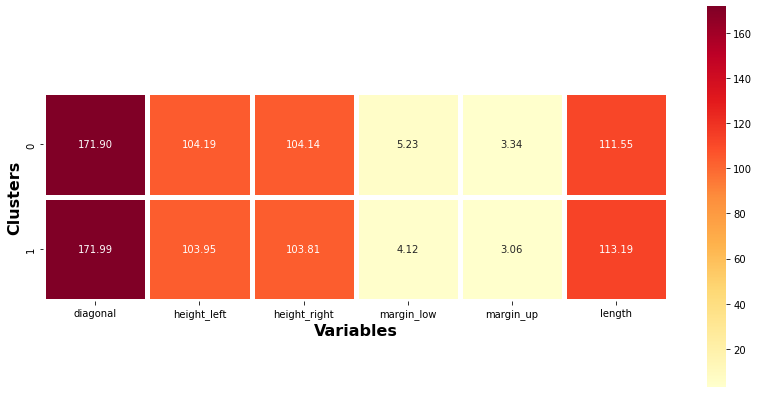

In [62]:
billets_centroid_df = pd.DataFrame(centroids_km, columns=X_train.columns)
fig2 = billets_centroid_df
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(fig2, linewidth=5, annot = True, fmt='.2f', cmap="YlOrRd", cbar_kws={"shrink": 0.5}, square=True)
plt.ylabel("Clusters",weight='bold',size=16)
plt.xlabel("Variables",weight='bold',size=16)
plt.show()

### Matrice de confusion (K-means)

In [63]:
production_kmean = kmeans.predict(X_test)

In [64]:
km_matrix = pd.crosstab(y_test,production_kmean)


In [65]:
# Graphique:
def matriceConfusion(mc,titre) :
    plt.figure(figsize=(8,5))
    sns.heatmap(mc, annot = True, fmt = ".3g",
                cmap = sns.color_palette("crest", as_cmap=True),
                linecolor = "white", linewidths = 0.3,
                xticklabels = ["Faux","Vrai"],
                yticklabels=["0(Faux)","1(Vrai)"]
                , annot_kws={"size":20})
    plt.xlabel("Prédictions", fontsize=15)
    plt.ylabel("Réalité",fontsize=15)
    plt.title(titre,fontsize=20)
    plt.show()

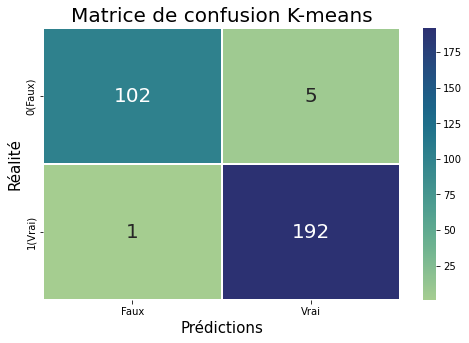

In [66]:
matriceConfusion(km_matrix,'Matrice de confusion K-means')

In [67]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,production_kmean))

              precision    recall  f1-score   support

       False       0.99      0.95      0.97       107
        True       0.97      0.99      0.98       193

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



In [68]:
# Model Precision
Precision_kmeans=metrics.precision_score(y_test,production_kmean)
print("Precision:",(Precision_kmeans).round(3))

# Model Recall
print("Recall:",(metrics.recall_score(y_test,production_kmean)).round(3))

Precision: 0.975
Recall: 0.995


### Prédictions avec K-means

In [69]:
# Predictions sur des donnees inconnues:
billets_production = pd.read_csv("billets_production.csv")
billets_production_test = billets_production.drop('id', axis=1)

billets_production["Prédiction K-means"] = kmeans.predict(billets_production_test)
billets_production['Prédiction K-means'].replace([1,0],[True,False], inplace=True)
display(billets_production[["id","Prédiction K-means"]])

,id,Prédiction K-means
0,A_1,False
1,A_2,False
2,A_3,False
3,A_4,True
4,A_5,True


## K-NN(K Nearest Neighbors)

Diminutif de K Nearest Neighbors.  
C’est un algorithme qui peut servir autant pour la classification que pour la régression. Il est surnommé « nearest neighbors »  car **le principe de ce modèle consiste en effet à choisir les k données les plus proches du point étudié afin d’en prédire sa valeur.**

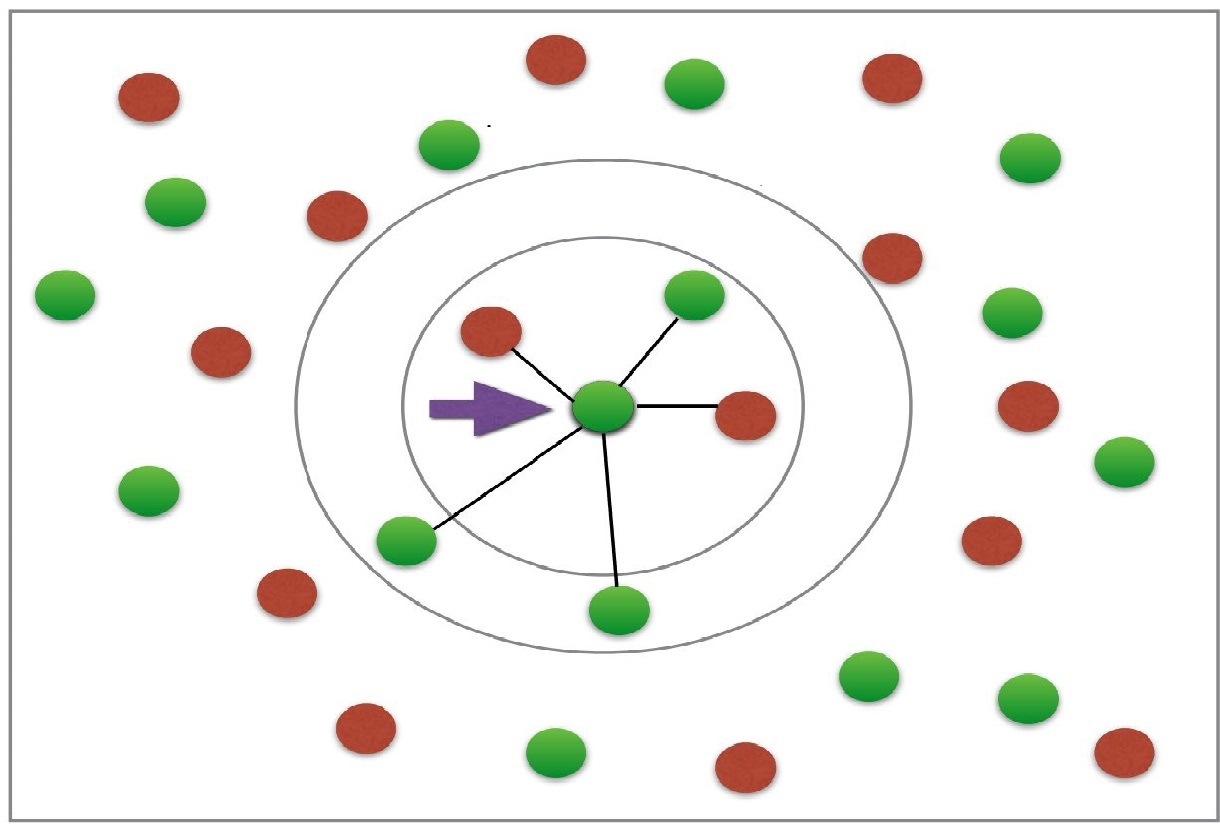

### Choisir le nombre optimal de K

k n'est pas un paramètre mais un hyperparamètre, c'est-à-dire que contrairement aux paramètres classiques, il ne va pas pouvoir être appris automatiquement par l'algorithme à partir des données d'entraînement. Les hyperparamètres permettent de caractériser le modèle (complexité, rapidité de convergence, etc). Ce ne sont pas les données d'apprentissage qui vont permettre de trouver ces paramètres (en l'occurrence ici, le nombre de voisins k), mais bien à nous de l'optimiser à l'aide du jeu de données test.

Pour trouver le k optimal, on va simplement tester le modèle pour tous les k de 1 à 15, mesurer l’erreur test et afficher la performance en fonction de k

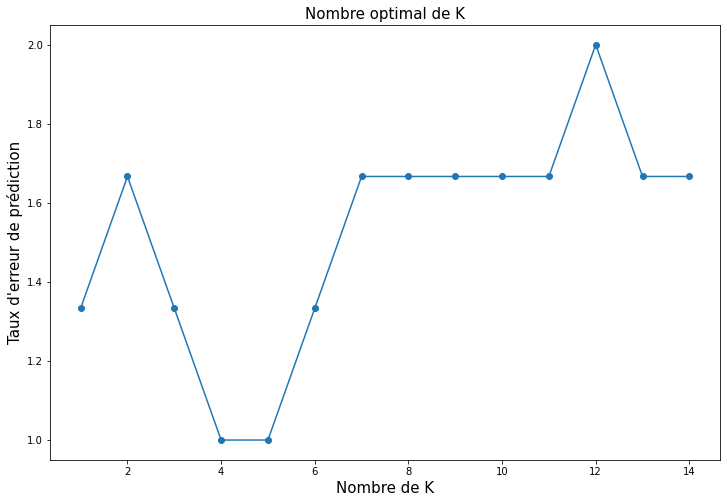

In [70]:
from sklearn import neighbors
errors = []
for k in range(1,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.figure(figsize=(12,8))
plt.plot(range(1,15), errors, 'o-')
plt.title('Nombre optimal de K',fontsize=15)
plt.ylabel("Taux d'erreur de prédiction",fontsize=15)
plt.xlabel('Nombre de K',fontsize=15)
plt.show()


In [71]:
dff = pd.DataFrame(errors, columns=['Erreur en pourcentage'])
dff['nombre de k']=range(1,15)
dff.sort_values(by='Erreur en pourcentage', ascending=True).head(5)

,Erreur en pourcentage,nombre de k
3,1.000000,4
4,1.000000,5
0,1.333333,1
2,1.333333,3
5,1.333333,6


Comme on peut le voir, le k-NN le plus performant est celui pour lequel k = 4 ou 5. On connaît donc notre classifieur final optimal : 5-nn. Ce qui veut dire que c'est celui qui classifie le mieux les données, et qui donc dans ce cas précis reconnaît au mieux les nombres écrits à la main.

 ### Création de modèle kNN

In [72]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

### Matrice de confusion (kNN)

In [73]:
y_pred_test_NN= knn.predict(X_test)

In [74]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred_test_NN)
cnf_matrix

array([[105,   2],
       [  1, 192]], dtype=int64)

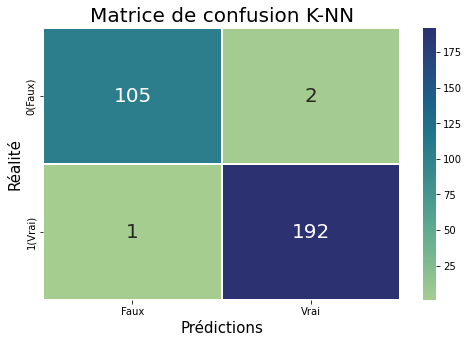

In [75]:
matriceConfusion(cnf_matrix,'Matrice de confusion K-NN')

In [76]:
# Classification report
target_names = ['Faux Billets', 'Vrai Billets']
print(classification_report(y_test,y_pred_test_NN, target_names=target_names))

              precision    recall  f1-score   support

Faux Billets       0.99      0.98      0.99       107
Vrai Billets       0.99      0.99      0.99       193

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [77]:
# Model Precision
Precision_kNN=metrics.precision_score(y_test,y_pred_test_NN)
print("Precision:",Precision_kNN)

# Model Recall
print("Recall:",metrics.recall_score(y_test,y_pred_test_NN))

Precision: 0.9896907216494846
Recall: 0.9948186528497409


### Prédictions avec kNN

In [78]:
billets_production = pd.read_csv("billets_production.csv")
billets_production["Prédiction K-NN"] = knn.predict(billets_production_test)
billets_production[['id','Prédiction K-NN']]

,id,Prédiction K-NN
0,A_1,False
1,A_2,False
2,A_3,False
3,A_4,True
4,A_5,True


## Régression logistique

Un modèle de régression logistique **permet aussi de prédire la probabilité qu’un événement arrive (valeur de 1) ou non (valeur de 0) à partir de l’optimisation des coefficients de régression.** Ce résultat varie toujours entre 0 et 1. Lorsque la valeur prédite est supérieure à un seuil, l’événement est susceptible de se produire, alors que lorsque cette valeur est inférieure au même seuil, il ne l’est pas.

La régression logistique est une méthode de classification (supervisée) qui permet de traiter des cas comme :

la prévision de présence/absence d'une maladie ;

la prévision de l'état de fonctionnement d'une machine-outil en fonction de ses caractéristiques (ancienneté, modèle, etc.), à des fins de maintenance prédictive ;

le credit scoring (attribution ou non d'un crédit).

### Création de l'algorithme de la régression logistique

In [79]:
# Rebuild datasets
dataset_train = pd.concat((X_train, y_train), axis=1).reset_index(drop=True)
dataset_test = pd.concat((X_test, y_test), axis=1).reset_index(drop=True)

In [80]:
reg_log_multi = smf.glm('is_genuine ~ diagonal+height_left+height_right+margin_low+margin_up+length', data=dataset_train, family=sm.families.Binomial()).fit()
print(reg_log_multi.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1193
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -29.119
Date:                                       Fri, 23 Dec 2022   Deviance:                       58.237
Time:                                               11:42:30   Pearson chi2:                 4.16e+03
No. Iterations:                                           11   Pseudo R-squ. (CS):             0.7037
Covariance Type:                                   nonrobust                      

* Retrait des variables non significatives

On va donc maintenant retirer les variables non significatives avec la procédure descendante ou backward une par une.

In [81]:
reg_log_multi = smf.glm('is_genuine ~ height_left+height_right+margin_low+margin_up+length', data=dataset_train, family=sm.families.Binomial(), random_state=11).fit()
print(reg_log_multi.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1194
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -29.183
Date:                                       Fri, 23 Dec 2022   Deviance:                       58.366
Time:                                               11:42:31   Pearson chi2:                 3.94e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7036
Covariance Type:                                   nonrobust                      

In [82]:
reg_log_multi = smf.glm('is_genuine ~ height_right+margin_low+margin_up+length', data=dataset_train, family=sm.families.Binomial(), random_state=11).fit()
print(reg_log_multi.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1195
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -29.745
Date:                                       Fri, 23 Dec 2022   Deviance:                       59.489
Time:                                               11:42:31   Pearson chi2:                 4.76e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7034
Covariance Type:                                   nonrobust                      

### Matrice de confusion (Régression logistique)

In [83]:
# notre algorithme predit las faux billets
dataset_test["proba"] = (reg_log_multi.predict(dataset_test)).round(4)
dataset_test["y_pred"] = reg_log_multi.predict(dataset_test) < 0.5
mtr_conf_reg=pd.crosstab(dataset_test['is_genuine'],dataset_test["y_pred"])

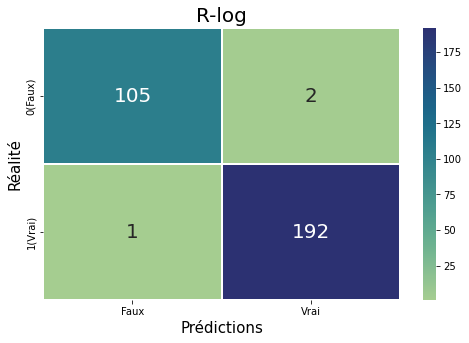

In [84]:
matriceConfusion(mtr_conf_reg,'R-log')

In [85]:
# Classification report
target_names = ['Faux Billets', 'Vrai Billets']
print(classification_report(dataset_test['is_genuine'],dataset_test["y_pred"], target_names=target_names))

              precision    recall  f1-score   support

Faux Billets       0.99      0.98      0.99       107
Vrai Billets       0.99      0.99      0.99       193

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [86]:
# Model Precision
Precision_reg=metrics.precision_score(dataset_test['is_genuine'],dataset_test["y_pred"])
print("Precision:",Precision_reg)

# Model Recall
print("Recall:",metrics.recall_score(dataset_test['is_genuine'],dataset_test["y_pred"]))

Precision: 0.9896907216494846
Recall: 0.9948186528497409


### La courbe ROC (Régression logistique)

La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de 1 – spécificité pour toutes les valeurs seuils possibles du marqueur étudié.

L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité. Une AUC de 0,5 (50%) indique que le marqueur est non-informatif. 

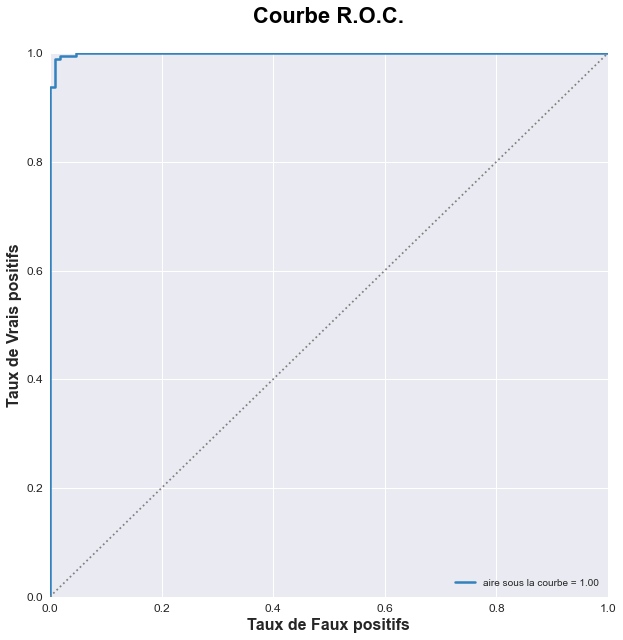

In [87]:
from sklearn.metrics import roc_auc_score, roc_curve
# Courbe R.O.C.:
fpr, tpr, _ = roc_curve(dataset_test['is_genuine'],1-dataset_test["proba"])
roc_auc = roc_auc_score(dataset_test['is_genuine'],1-dataset_test["proba"])

# Graphique:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Courbe R.O.C.",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(True)

plt.plot(fpr, tpr, color="#3182bd", linewidth=2.5, label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de Vrais positifs", weight='bold', size=16)
plt.xlabel("Taux de Faux positifs", weight='bold', size=16)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.show()

In [88]:
roc_auc

0.9991767953125756

### Prédiction avec la Régression logistique

In [89]:
billets_production = pd.read_csv("billets_production.csv")
billets_production['Prediction RegLog'] = reg_log_multi.predict(billets_production) < 0.5
billets_production[['id','Prediction RegLog']]

,id,Prediction RegLog
0,A_1,False
1,A_2,False
2,A_3,False
3,A_4,True
4,A_5,True


## Support Vector Machines

Les machines à vecteurs de support ou support vector machines sont des algorithmes d'apprentissage utilisés en machine learning pour résoudre des problèmes de classification, de régression ou de détection d'anomalie.

Le principe des SVM consiste à ramener un problème de classification ou de discrimination à un hyperplan (feature space) dans lequel les données sont séparées en plusieurs classes dont la frontière est la plus éloignée possible des points de données (ou "marge maximale"). D'où l'autre nom attribué aux SVM : les séparateurs à vaste marge. Le concept de frontière implique que les données soient linéairement séparables. Pour y parvenir, les support vector machines font appel à des noyaux, c'est-à-dire des fonctions mathématiques permettant de projeter et séparer les données dans l'espace vectoriel, les "vecteurs de support" étant les données les plus proches de la frontière. C'est la frontière la plus éloignée de tous les points d'entraînement qui est optimale, et qui présente donc la meilleure capacité de généralisation.

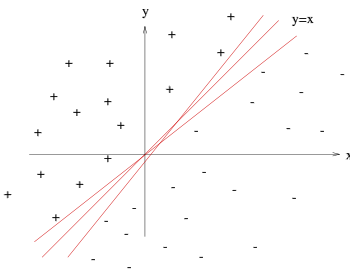

### Création de l'algorithme Support Vector Machines

In [90]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear', random_state = 0) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

### Matrice de confusion (SVM)

In [91]:
cnf_matrix_v = metrics.confusion_matrix(y_test,y_pred)

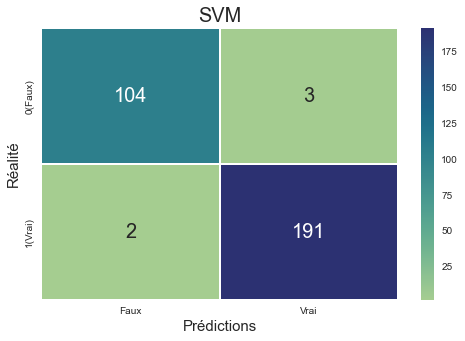

In [92]:
matriceConfusion(cnf_matrix_v,'SVM')

In [93]:
# Classification report
target_names = ['Faux Billets', 'Vrai Billets']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Faux Billets       0.98      0.97      0.98       107
Vrai Billets       0.98      0.99      0.99       193

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [94]:
# Model Precision: what percentage of positive tuples are labeled as such?
Precision_svm=metrics.precision_score(y_test, y_pred)
print("Precision:",Precision_svm)

# Model Recall: what percentage of positive tuples are labelled as such?

print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.9845360824742269
Recall: 0.9896373056994818


## Conclusion

In [95]:
df = pd.DataFrame({'Précision en %': [Precision_kmeans, Precision_kNN, Precision_reg,Precision_svm] },
                      index = ['K-means', 'kNN', 'Régression logistique','SVM'])

df['Précision en %']=(df['Précision en %']*100).round(4)
df

,Précision en %
K-means,97.4619
kNN,98.9691
Régression logistique,98.9691
SVM,98.4536


## Fonction de détection les vrais des faux billets

In [96]:
def prog_vérfication_billets(csv):
    billet_test= pd.read_csv(csv)
    billet_value=billet_test.drop('id', axis=1)
    billet_test['Prédiction RegLog'] = reg_log_multi.predict(billet_test) < 0.5
    billet_test['Prob Vrai']=(1-(reg_log_multi.predict(billet_test))).round(3)
    billet_test["Prédiction K-means"] = kmeans.predict(billet_value)
    billet_test['Prédiction K-means'].replace([1,0],[True,False], inplace=True)
    billet_test['Prédiction K-nn'] = knn.predict(billet_value)
    billet_test['Prédiction SVM'] = clf.predict(billet_value)
    
 
    billets_predict = billet_test[['id','Prob Vrai','Prédiction RegLog','Prédiction K-means','Prédiction K-nn','Prédiction SVM']].set_index("id")
    return billets_predict



In [97]:
# Tester la fonction
prog_vérfication_billets('billets_production.csv')

,Prob Vrai,Prédiction RegLog,Prédiction K-means,Prédiction K-nn,Prédiction SVM
id,,,,,
A_1,0.000,False,False,False,False
A_2,0.000,False,False,False,False
A_3,0.000,False,False,False,False
A_4,0.997,True,True,True,True
A_5,1.000,True,True,True,True


In [99]:
prog_vérfication_billets('billets_test.csv')

,Prob Vrai,Prédiction RegLog,Prédiction K-means,Prédiction K-nn,Prédiction SVM
id,,,,,
B_1,0.999,True,True,True,True
B_2,0.000,False,False,False,False
B_3,1.000,True,True,True,True
B_4,0.000,False,False,False,False
B_5,0.001,False,False,False,False
